## Import Libraries

In [ ]:
import tensorflow as tf
import random
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

## Data Augumentation and Normalization

Set up data augmentation and normalization for training images using ImageDataGenerator.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import matplotlib.pyplot as plt

# Parameters
image_dir = r'/content/drive/MyDrive/Faulty_solar_panel/Faulty_solar_panel'
img_size = 224
batch_size = 32
num_classes = 6
epochs = 20
fine_tune_epochs = 10  # Number of epochs for fine-tuning

#Data Augmentation + Normalization (rescale = normalize 0-1)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Data Loading

Loading and preparing the training and validation image datasets using data generators.

In [ ]:
# Data generators
train_gen = train_datagen.flow_from_directory(
    image_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    image_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 711 images belonging to 6 classes.
Found 174 images belonging to 6 classes.


## Balancing the Dataset

Balancing the dataset by analyzing class distribution and computing class weights to address class imbalance during training.

Class distribution: Counter({np.int32(0): 166, np.int32(1): 155, np.int32(2): 152, np.int32(5): 99, np.int32(3): 83, np.int32(4): 56})
Class weights: {np.int32(0): 0.713855421686747, np.int32(1): 0.7645161290322581, np.int32(2): 0.7796052631578947, np.int32(3): 1.427710843373494, np.int32(4): 2.1160714285714284, np.int32(5): 1.196969696969697}


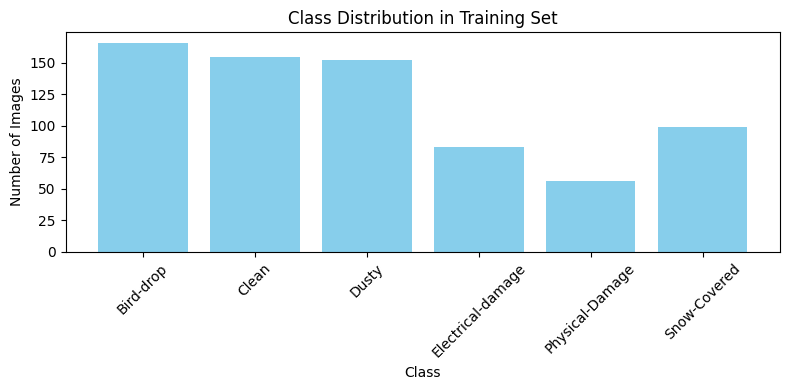

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
#  Check class distribution
class_counts = Counter(train_gen.classes)
print("Class distribution:", class_counts)

#  Compute class weights
total_samples = sum(class_counts.values())
class_weights = {
    i: total_samples / (len(class_counts) * class_counts[i])
    for i in class_counts
}
print("Class weights:", class_weights)

#  Plot class distribution
labels = list(train_gen.class_indices.keys())
counts = [class_counts[i] for i in range(len(labels))]

plt.figure(figsize=(8, 4))
plt.bar(labels, counts, color='skyblue')
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

## TransferLearning

Perform transfer learning by using a pretrained MobileNetV2 model as the base and adding a custom classification head for a new task.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# Load MobileNetV2
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet',alpha=1.3)
base_model.trainable = False  # Freeze base model

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

15441408/15441408 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Model Training

Train the model - including initial training, fine-tuning, applying callbacks, and saving the final model.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Train the model with class weights
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop, lr_reduce]
)
# Fine-Tuning Step: Unfreeze the top layers of the MobileNetV2 base model
base_model.trainable = True
fine_tune_start_layer = 100
for layer in base_model.layers[:fine_tune_start_layer]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_start_layer:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=fine_tune_epochs,
    class_weight=class_weights,
    callbacks=[early_stop, lr_reduce]
)

# Save model
model.save('solar_panel_classifier_correcting.h5')

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7106 - loss: 1.3113 - val_accuracy: 0.5805 - val_loss: 1.4218 - learning_rate: 1.0000e-05
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7140 - loss: 1.2743 - val_accuracy: 0.6552 - val_loss: 1.3885 - learning_rate: 1.0000e-05
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7345 - loss: 1.1898 - val_accuracy: 0.6667 - val_loss: 1.4034 - learning_rate: 1.0000e-05
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7599 - loss: 1.1482 - val_accuracy: 0.6322 - val_loss: 1.4025 - learning_rate: 1.0000e-05
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7774 - loss: 1.1410 - val_accuracy: 0.6494 - val_loss: 1.3654 - learning_rate: 1.0000e-05
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7317 - loss: 1.1321 - val_accuracy: 0.5920 - val_loss: 1.4318 - learning_rate: 1.0000e-05
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7559 - loss:

## Visualization

Performs visualization of the training and fine-tuning accuracy over epochs.

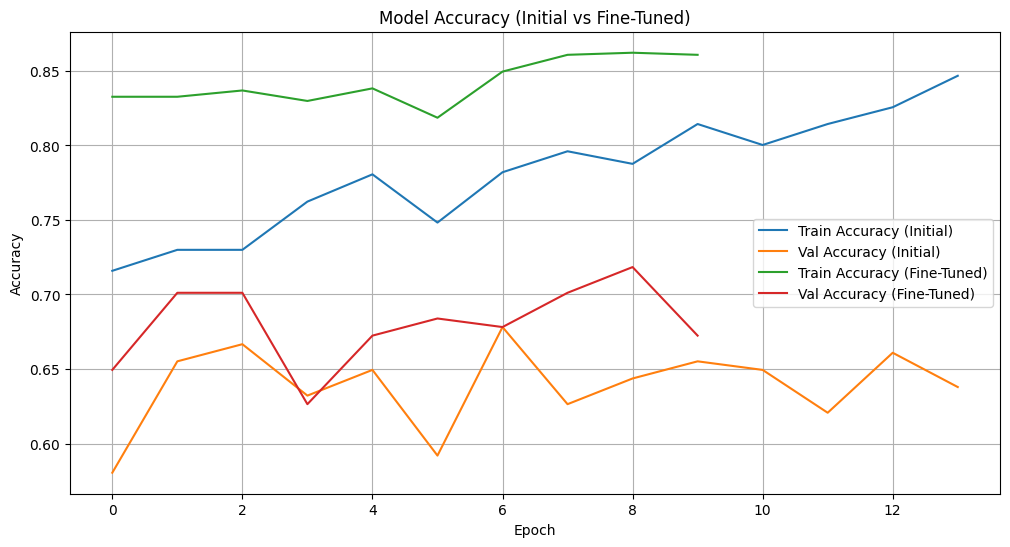

In [ ]:
# Plot accuracy for training and fine-tuning
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy (Initial)')
plt.plot(history.history['val_accuracy'], label='Val Accuracy (Initial)')
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy (Fine-Tuned)')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy (Fine-Tuned)')
plt.title('Model Accuracy (Initial vs Fine-Tuned)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

Performing evaluation of the model using predictions, classification report, and confusion matrix.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step

Classification Report:

                   precision    recall  f1-score   support

        Bird-drop     0.7500    0.7317    0.7407        41
            Clean     0.6111    0.8684    0.7174        38
            Dusty     0.6471    0.8684    0.7416        38
Electrical-damage     1.0000    0.3500    0.5185        20
  Physical-Damage     1.0000    0.6923    0.8182        13
     Snow-Covered     1.0000    0.5417    0.7027        24

         accuracy                         0.7184       174
        macro avg     0.8347    0.6754    0.7065       174
     weighted avg     0.7791    0.7184    0.7108       174



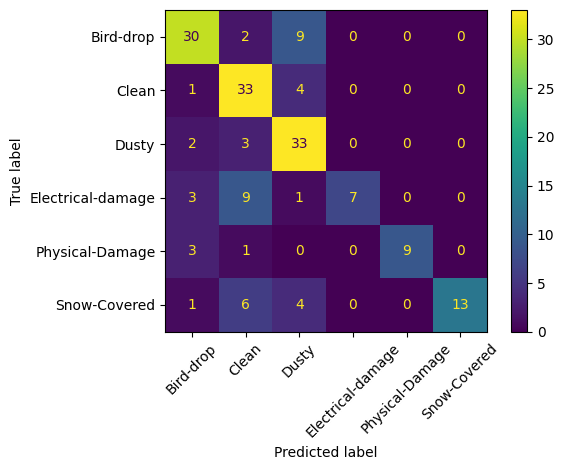

In [ ]:
# Predict on validation set
val_gen.reset()
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes

# Labels
class_labels = list(val_gen.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print("\nClassification Report:\n")
print(report)

# Optional: Save to file
with open("classification_report_effnet.txt", "w") as f:
    f.write(report)


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=45)
plt.tight_layout()
plt.show()

## Prediction

Performing inspection of the model’s predictions by visually comparing predicted vs. true labels on sample validation images.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/tmp/ipython-input-3007255911.py:29: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


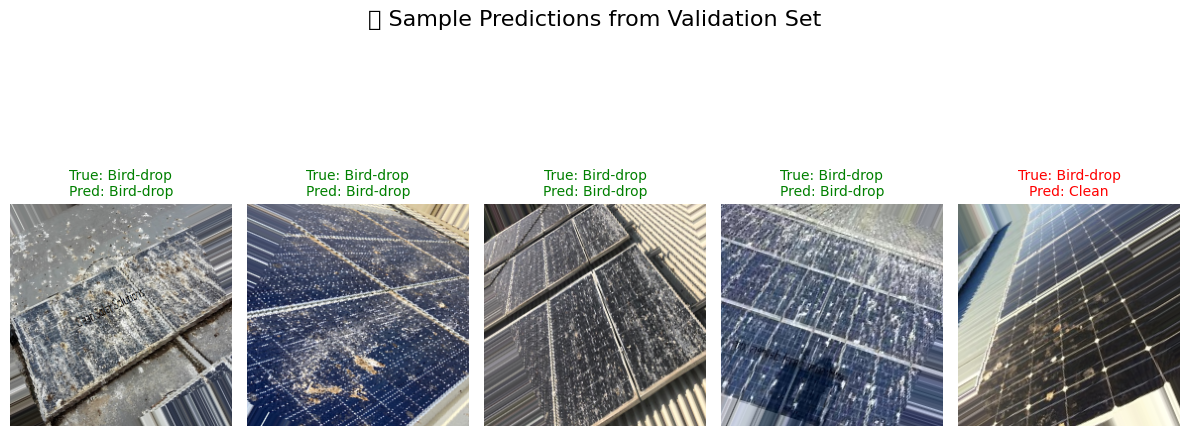

In [ ]:
# 🔍 Sample Predictions
# Get class labels
class_names = list(train_gen.class_indices.keys())

# Fetch one batch from validation set
val_images, val_labels = next(val_gen)

# Predict
preds = model.predict(val_images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(val_labels, axis=1)

# Visualize predictions for 5 random images
plt.figure(figsize=(12, 6))
for i in range(5):
    idx = random.randint(0, len(val_images) - 1)
    img = val_images[idx]
    true_label = class_names[true_classes[idx]]
    predicted_label = class_names[pred_classes[idx]]

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {predicted_label}",
              fontsize=10,
              color=("green" if true_label == predicted_label else "red"))

plt.suptitle("🔍 Sample Predictions from Validation Set", fontsize=16)
plt.tight_layout()
plt.show()